In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from astropy.cosmology import z_at_value
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
import astropy.units as u

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
alldb = pd.read_pickle('../dataframes/fitdb/allfits_1D.pkl')
morph_db = alldb.query('W_UVJ == "Q" and AGN != "AGN" and lmass >= 10.5 and n_f < 3 and Re < 20 ')

bspec = [27458,294464,36348,48631,19290,32566,32691,33093,26272,35640,45333, 30144]
# nog141 = [27915,37955,17746,17735]
nog102 = [27714,37189,26139,32799,47223,22774,28890,23073,31452,24033]
# nog102 = []

inout = []
for i in morph_db.index:     
    if morph_db.id[i] not in bspec and morph_db.id[i] not in nog102: 
        inout.append('i')
    else:
        inout.append('o')
        
morph_db['inout'] = inout
mdb = morph_db.query('inout == "i" and 0.7 < zgrism < 2.5 and Sigma1 > 10**9.6')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


# check rolling SFH

In [4]:
from spec_stats import Leave_one_out
def Sum_SFH(lbt, sfh):
    return np.sum(SFH_grid, axis=0)

def Sum_SFH_bs(lbt, sfh, its = 1000):
    sfh_bs = []
    dt_bs = []
    w = Leave_one_out(np.array(sfh), lbt)
    wsfh = [w[U]*sfh[U] for U in range(len(sfh))]
    for xx in range(its):
        IDX = np.random.choice(range(len(sfh)) , len(sfh))            
        S= np.sum(np.array(wsfh)[IDX], axis=0)
#         S= np.sum(np.array(sfh)[IDX], axis=0)
        istack = interp1d(lbt,S, bounds_error=False, fill_value=0)(lbt)
        sfh_bs.append(istack)
        iT = interp1d(np.cumsum(istack[::-1]) / np.cumsum(istack[::-1])[-1], lbt - min(lbt))
        dt_bs.append(iT(0.9) - iT(0.5))
        
    sfh_bs = np.array(sfh_bs)
    dt_bs = np.array(dt_bs)
    
    ################   
    SFH = []
    SFH16 = []
    SFH84 = []
    ltimes = []

    for i in range(len(sfh_bs.T)):
        gdat = sfh_bs.T[i][sfh_bs.T[i]>0]
        
        if len(gdat) > 0:
            SFH.append(np.percentile(gdat,50))
            SFH16.append(np.percentile(gdat,16))
            SFH84.append(np.percentile(gdat,84))
            ltimes.append(lbt[i])

    DT = np.percentile(dt_bs,50)
    DT16 = np.percentile(dt_bs,16)
    DT84 = np.percentile(dt_bs,84)
            
    SFH = np.array(SFH)
    SFH16 = np.array(SFH16)
    SFH84 = np.array(SFH84)
    LBT = np.array(ltimes)
    return LBT, SFH, SFH16, SFH84, DT, DT16, DT84

In [5]:
S1db = mdb.sort_values('zgrism')


In [9]:
import pickle
from make_sfh_tool import Gen_SFH

idx = 0
LBT = np.linspace(0,14, 1000)
L=[]
S=[]
Sl=[]
Sh=[]
DT=[]
DTl=[]
DTh=[]

zg = []
M = []
while idx < len(S1db.index)-14:
    SFH_grid = []
    s1_grid = []
    M_grid = []
    for i in S1db.index[idx:idx + 15]:
        try:
            lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(S1db.field[i], S1db.id[i]))
            
        except:
            try:
                with open('../data/SFH/{}_{}.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH 
                
            except:
                with open('../data/SFH/{}_{}_1D.pkl'.format(S1db.field[i], S1db.id[i]), 'rb') as sfh_file:
                    sfh = pickle.load(sfh_file)
                lbt = sfh.LBT 
                sfh = sfh.SFH                
                
        isfh = interp1d(lbt+cosmo.lookback_time(S1db.zgrism[i]).value,sfh, bounds_error=False, fill_value=0)(LBT)
        SFH_grid.append(isfh)
        s1_grid.append(S1db.zgrism[i])
        M_grid.append(10**S1db.lmass[i])
    
    L1,S1,S16,S84,dt, dt16, dt84  = Sum_SFH_bs(LBT, SFH_grid)
    L.append(L1)
    S.append(S1)
    Sl.append(S16)
    Sh.append(S84)
    DT.append(dt)
    DTl.append(dt16)
    DTh.append(dt84)
    
    zg.append(np.mean(s1_grid))
    M.append(np.mean(M_grid))
    
    idx+=1

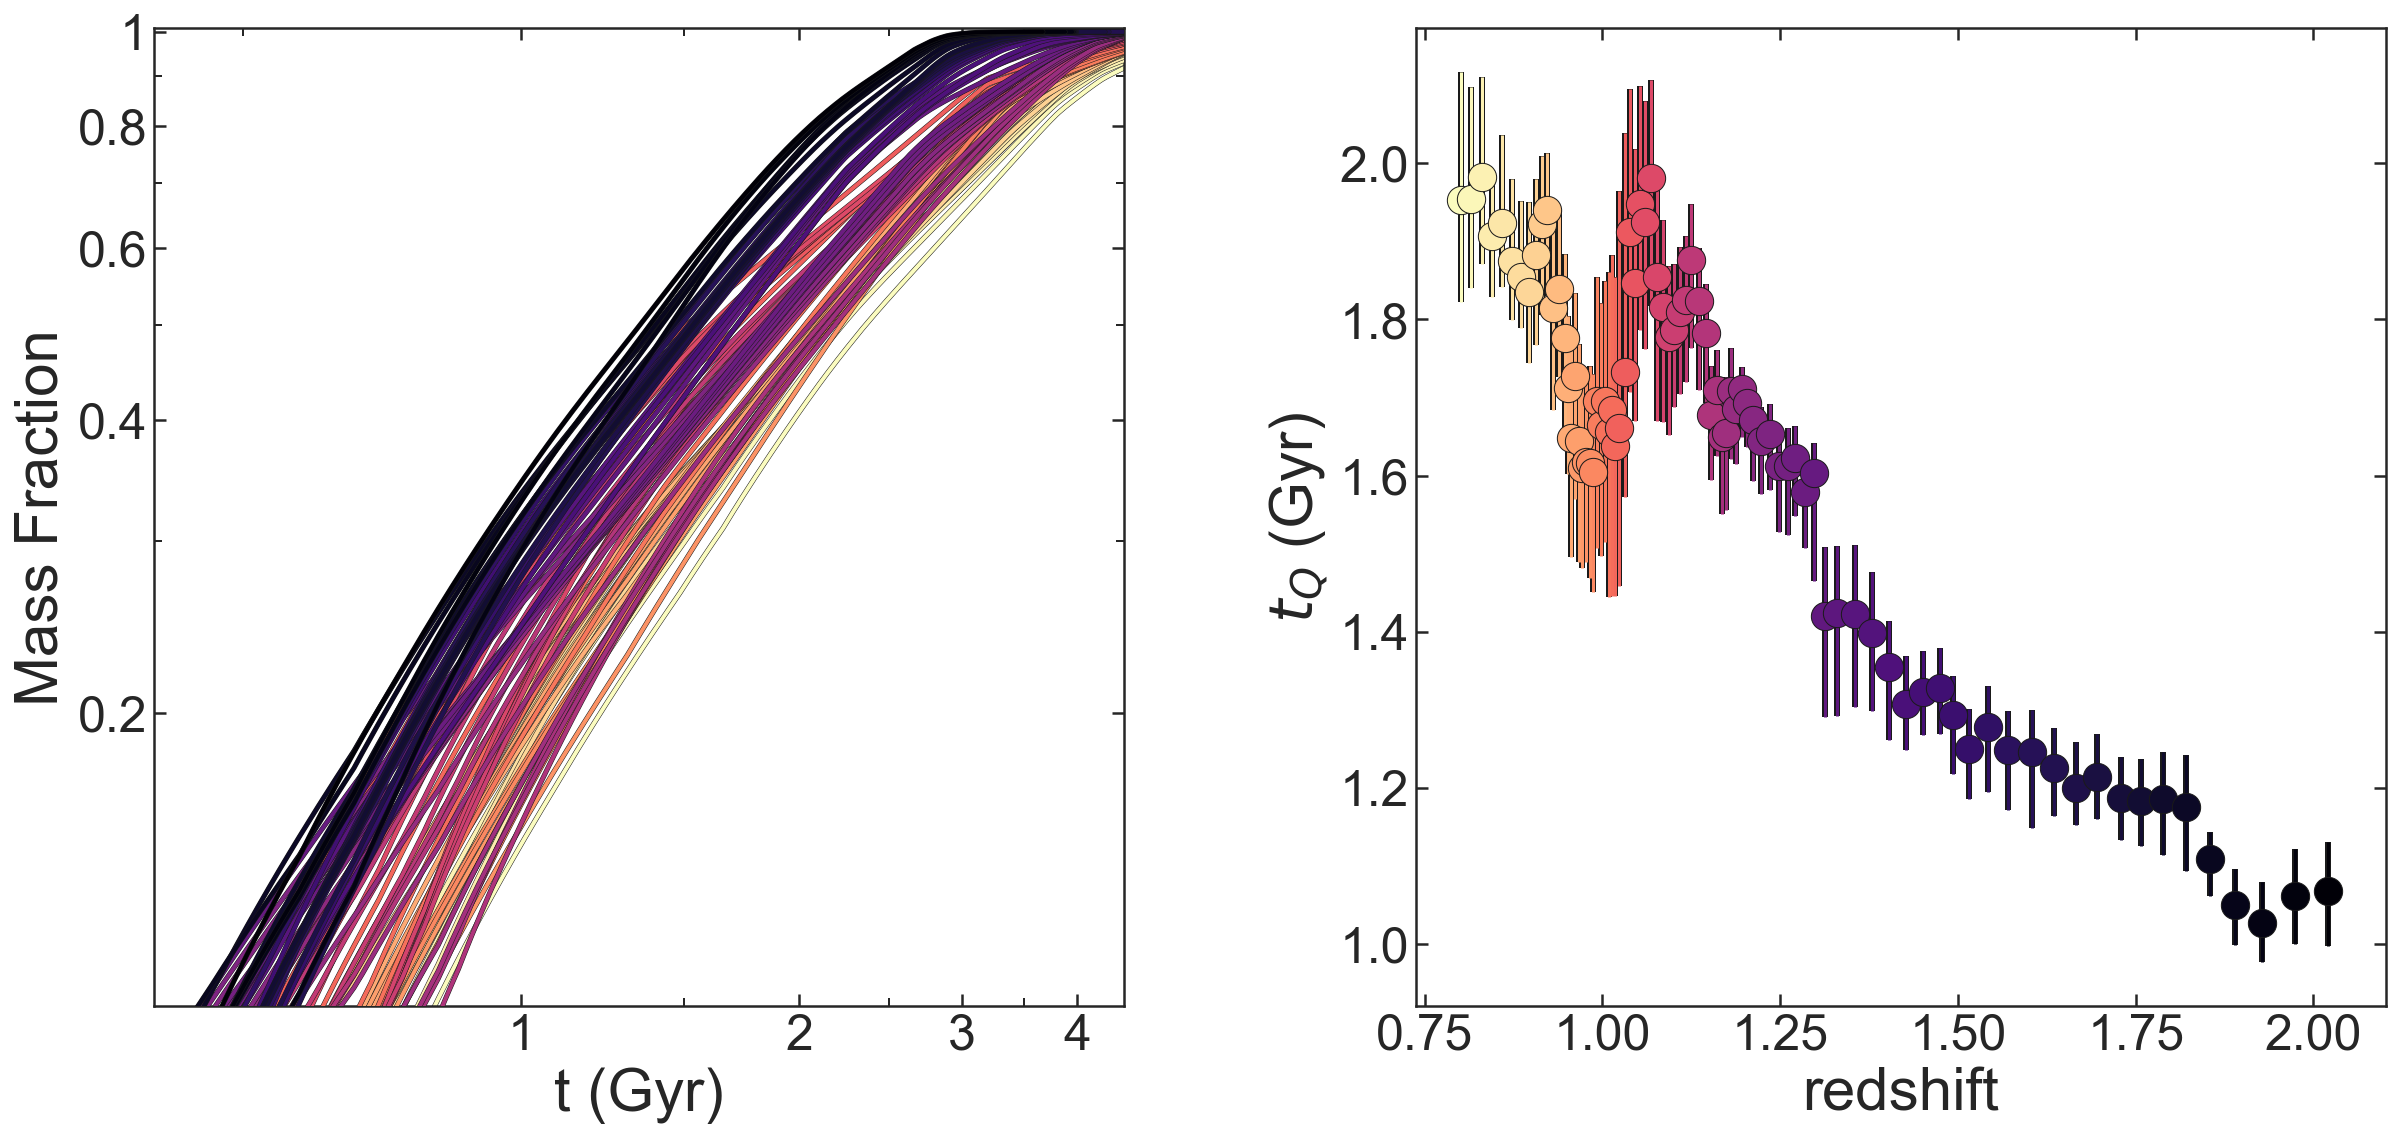

In [14]:
from matplotlib import cm
from matplotlib import colors
norm = colors.Normalize(vmin=0, vmax=len(L))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

gs = gridspec.GridSpec(1,2, wspace=0.3)

plt.figure(figsize =[20,9])
ax2 = plt.subplot(gs[0])
ax3 = plt.subplot(gs[1])

######## C SFH
idx = 0
for i in range(len(L)):
    ax2.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
             linewidth = 2, zorder = idx + 1)
    ax2.plot(L[i] - min(L[i]), np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],color = 'k', linewidth = 2.5, zorder = idx)
    idx+=1
ax2.set_ylabel('Mass Fraction', fontsize=30)
ax2.set_xlabel('t (Gyr)', fontsize=30)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.4,4.5)
ax2.set_ylim(0.1,1.01)
ax2.set_xticks([1,2,3,4])
ax2.set_xticklabels([1,2,3,4])
ax2.set_xticks([0.5,1.5,2.5,3.5], minor=True)
ax2.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticks([0.3,0.5,0.7,0.9], minor=True)

ax2.tick_params(axis='both', which='major', labelsize=25)

########## delta t    
dt = []
for i in range(len(L)):
    iT = interp1d(np.cumsum(S[i][::-1]) / np.cumsum(S[i][::-1])[-1],L[i] - min(L[i]))
    ax3.errorbar(zg[i],iT(0.9)-iT(0.5), yerr = [[iT(0.9)-iT(0.5)-DTl[i]],[DTh[i]-(iT(0.9)-iT(0.5))]], fmt='o',
                color = 'k', zorder =1, elinewidth = 3)
    ax3.errorbar(zg[i],iT(0.9)-iT(0.5), yerr = [[iT(0.9)-iT(0.5)-DTl[i]],[DTh[i]-(iT(0.9)-iT(0.5))]], fmt='o',
                color =  np.array(cm.magma_r(norm(i),bytes=True))/255, zorder =2)
    ax3.scatter(zg[i],iT(0.9)-iT(0.5),color =  np.array(cm.magma_r(norm(i),bytes=True))/255, 
                edgecolors='k', linewidths=0.5,s = 200, zorder =3 )

ax3.set_ylabel('$t_Q$ (Gyr)', fontsize=30)
ax3.set_xlabel('redshift', fontsize=30)
ax3.tick_params(axis='both', which='major', labelsize=25)
sz= 3.2


(0, 6)

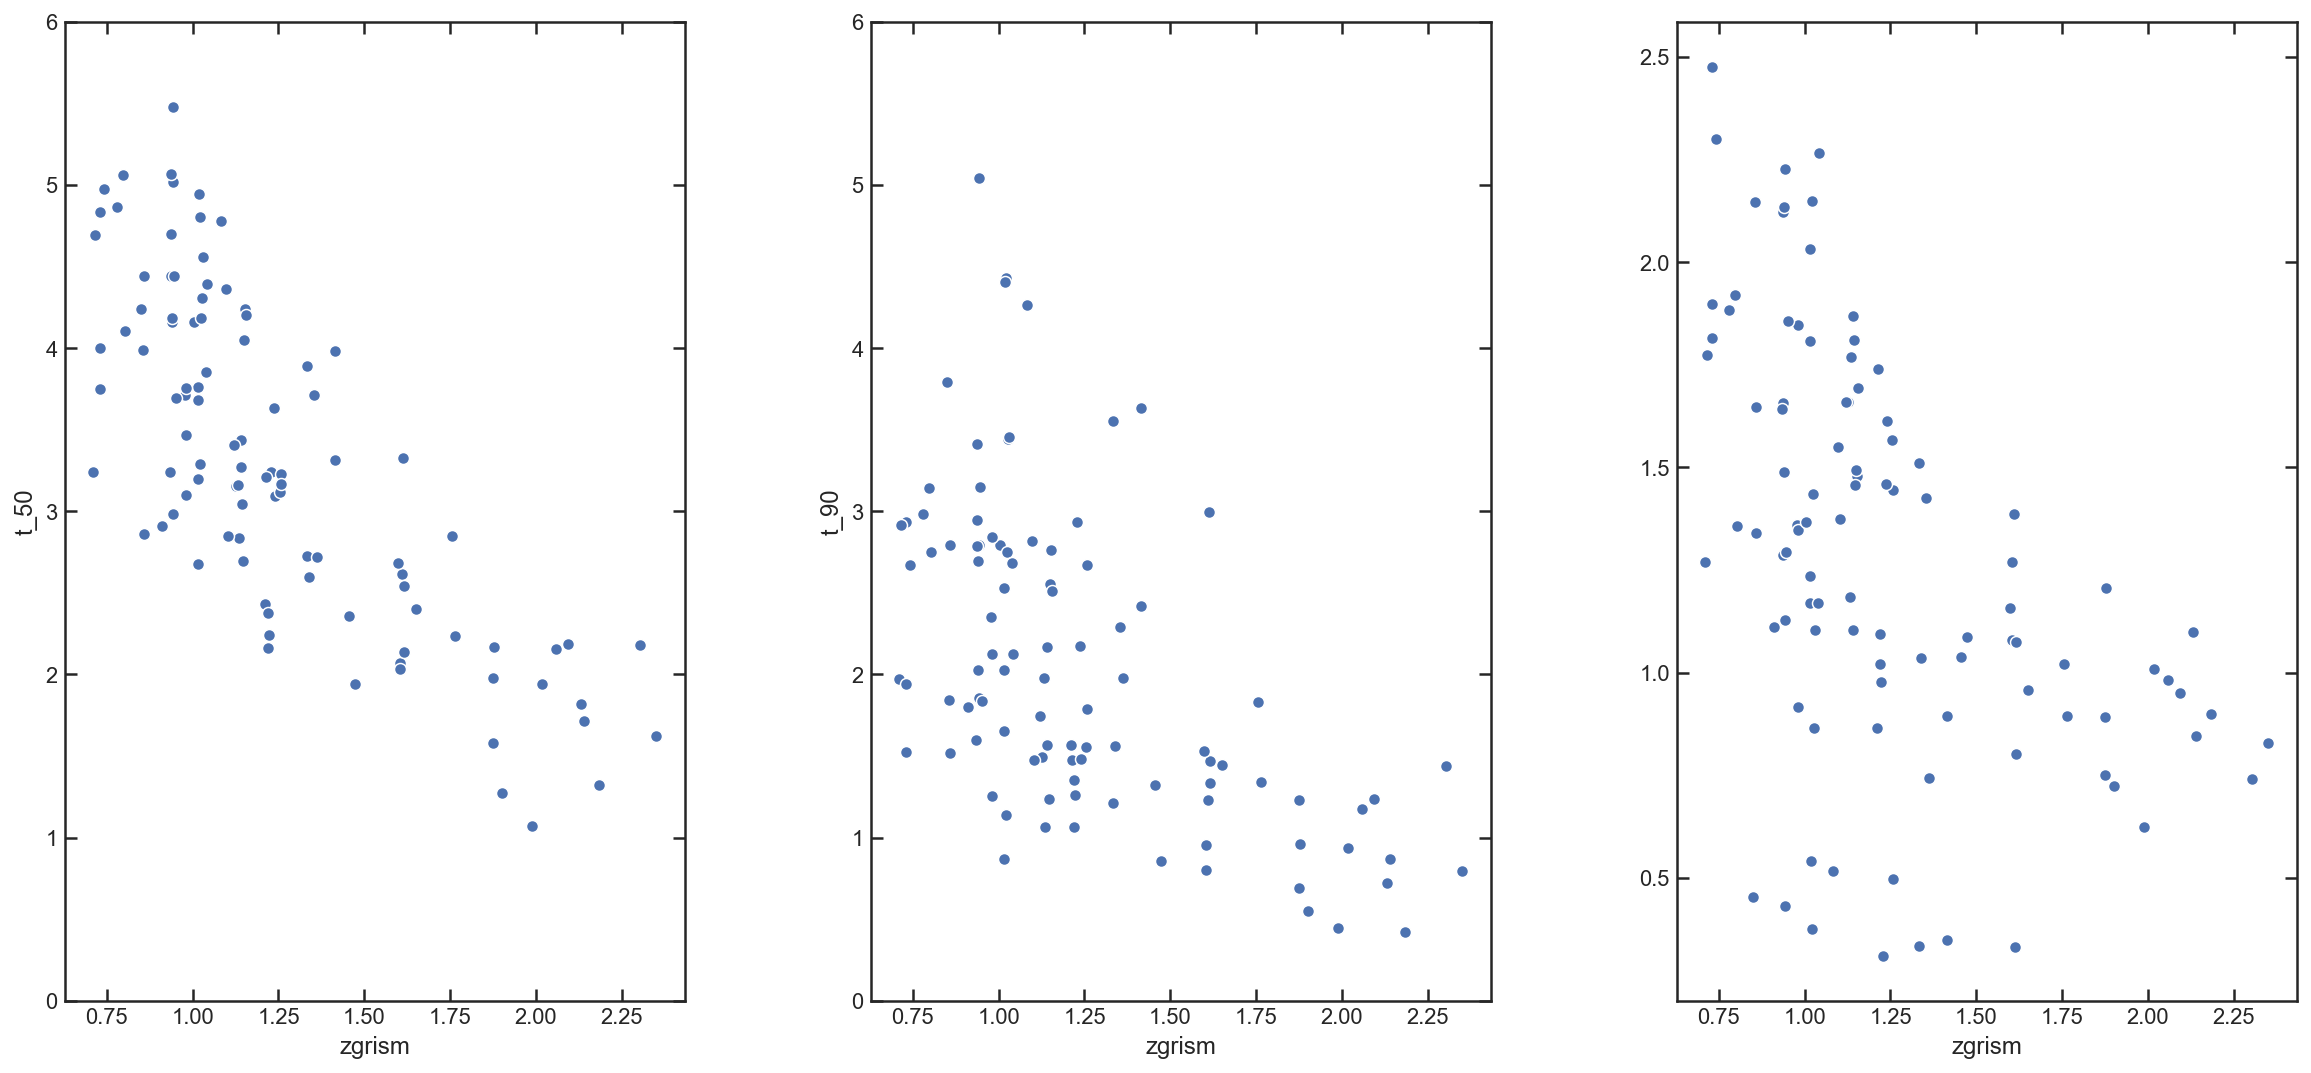

In [17]:
gs = gridspec.GridSpec(1,3, wspace=0.3)

plt.figure(figsize =[20,9])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

sea.scatterplot(mdb.zgrism, mdb.t_50, ax = ax1)
sea.scatterplot(mdb.zgrism, mdb.t_90, ax = ax2)
sea.scatterplot(mdb.zgrism, mdb.t_50 - mdb.t_90, ax = ax3)

ax1.set_ylim(0,6)
ax2.set_ylim(0,6)

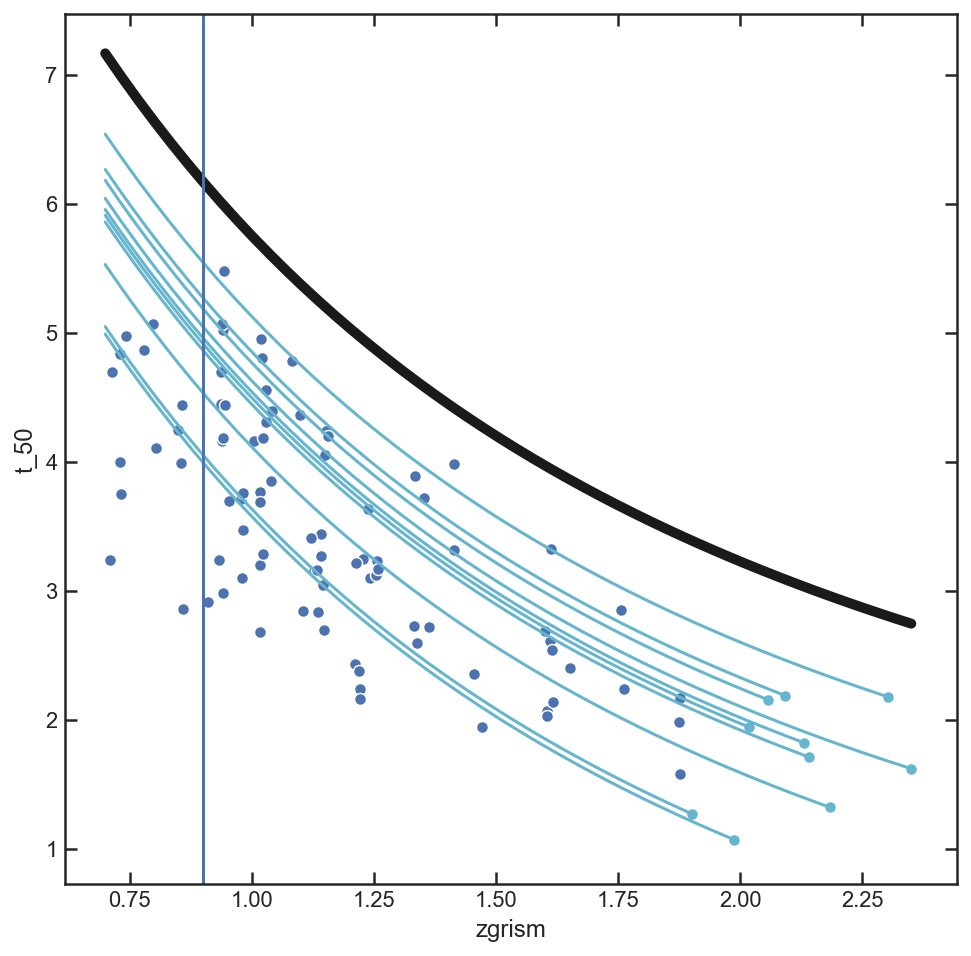

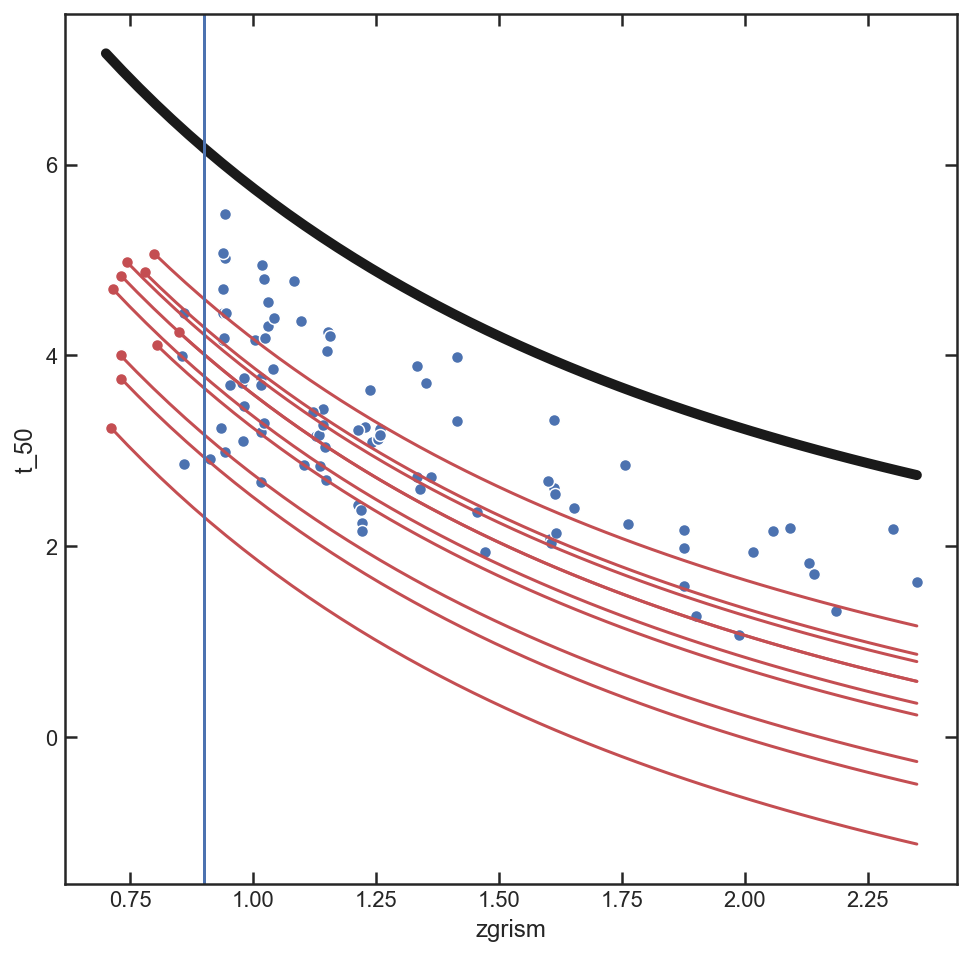

In [68]:
plt.figure(figsize =[8,8])

sea.scatterplot(mdb.zgrism, mdb.t_50)

for i in S1db.index[-10:]:  
    z_init = mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism.values[0]
    a_init = cosmo.age(z_init).value
    zs = np.linspace(0.7, z_init)
    a = cosmo.age(zs).value
    a -= a_init
    sea.scatterplot(mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism, 
                    mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50, color = 'c')
    plt.plot(zs, mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50.values[0] + a, color = 'c')
plt.plot(np.linspace(0.7,2.35), cosmo.age(np.linspace(0.7,2.35)), 'k', linewidth = 5)

plt.axvline(0.9)
    
    
plt.figure(figsize =[8,8])

sea.scatterplot(mdb.zgrism, mdb.t_50)
for i in S1db.index[:10]:
    z_init = mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism.values[0]
    a_init = cosmo.age(z_init).value
    zs = np.linspace(z_init, 2.35)
    a = cosmo.age(zs).value
    a -= a_init
    sea.scatterplot(mdb.query('zgrism == {} '.format(mdb.zgrism[i])).zgrism, 
                    mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50, color = 'r')
    plt.plot(zs, mdb.query('zgrism == {} '.format(mdb.zgrism[i])).t_50.values[0] + a, color = 'r')

    
plt.plot(np.linspace(0.7,2.35), cosmo.age(np.linspace(0.7,2.35)), 'k', linewidth = 5)

plt.axvline(0.9)

old 22358 9.767971939198802
old 23459 10.006211639767342
old 36838 9.939367297801896
old 13774 10.137551878955287
old 47140 9.709204660042753
old 27006 10.13310760652903


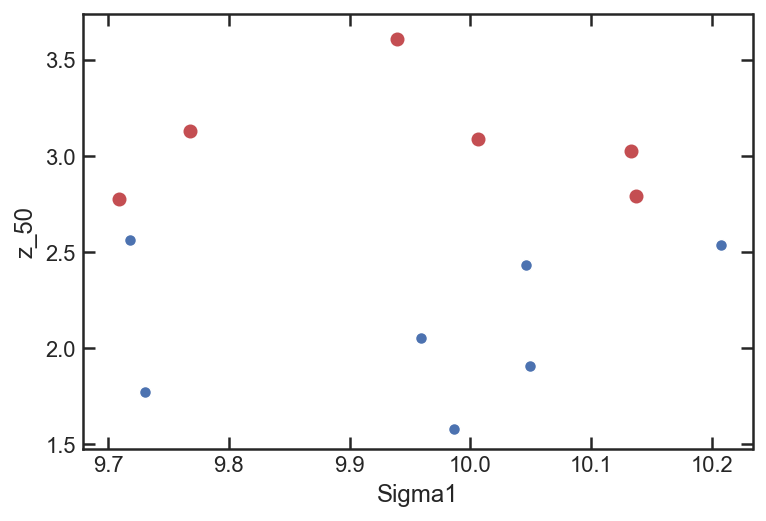

In [104]:
z_init = mdb.query('1.98 < zgrism < 2.01 ').zgrism.values[0]
a_init = cosmo.age(z_init).value
zs = np.linspace(0.7, z_init)
a = cosmo.age(zs).value
a -= a_init

ilim = interp1d(zs, mdb.query('1.98 < zgrism < 2.01 ').t_50.values[0] + a)


sea.scatterplot(np.log10(mdb.query('zgrism < 0.9').Sigma1), mdb.query('zgrism < 0.9').z_50)

for i in mdb.query('zgrism < 0.9').index:
    if mdb.t_50[i] >= ilim(mdb.zgrism[i]):
        plt.scatter(np.log10(mdb.Sigma1[i]), mdb.z_50[i], color = 'r')
        print('old ' + str(mdb.id[i]), np.log10(mdb.Sigma1[i]))
#     else:
#         print('young ' + str(mdb.id[i]), np.log10(mdb.Sigma1[i]))
        

In [107]:

for i in S1db.index[-10:]:
    print(mdb.id[i])

24569
24315
14132
43572
21738
32933
17599
44133
23018
48464


In [116]:
import pickle
from make_sfh_tool import Gen_SFH

field = 'GND'
gid = 23018

try:
    lbt, sfh = np.load('../data/SFH/{0}_{1}.npy'.format(field, gid))

except:
    try:
        with open('../data/SFH/{}_{}.pkl'.format(field, gid), 'rb') as sfh_file:
            sfh = pickle.load(sfh_file)
        lbt = sfh.LBT 
        sfh = sfh.SFH 

    except:
        with open('../data/SFH/{}_{}_1D.pkl'.format(field, gid), 'rb') as sfh_file:
            sfh = pickle.load(sfh_file)
        lbt = sfh.LBT 
        sfh = sfh.SFH                

lbt2 = lbt
sfh2 = sfh

235    2.301924
Name: zgrism, dtype: float64
3.8331283450464637 Gyr


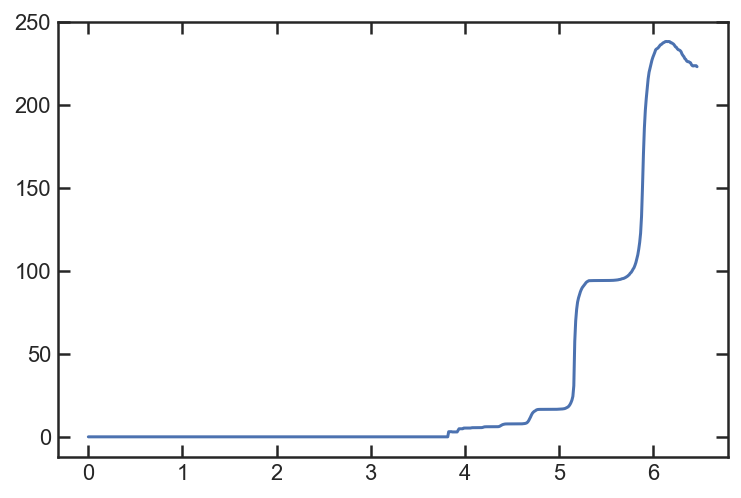

In [124]:
print(mdb.query('id == 23018').zgrism)
print(cosmo.age(0.8) - cosmo.age(2.3))
plt.plot(np.append(np.linspace(0,3.82,500) ,3.83 + lbt2), np.append(np.zeros(500),sfh2))

In [123]:
np.linspace(0,3.82,500)

array([0.        , 0.00765531, 0.01531062, 0.02296593, 0.03062124,
       0.03827655, 0.04593186, 0.05358717, 0.06124248, 0.0688978 ,
       0.07655311, 0.08420842, 0.09186373, 0.09951904, 0.10717435,
       0.11482966, 0.12248497, 0.13014028, 0.13779559, 0.1454509 ,
       0.15310621, 0.16076152, 0.16841683, 0.17607214, 0.18372745,
       0.19138277, 0.19903808, 0.20669339, 0.2143487 , 0.22200401,
       0.22965932, 0.23731463, 0.24496994, 0.25262525, 0.26028056,
       0.26793587, 0.27559118, 0.28324649, 0.2909018 , 0.29855711,
       0.30621242, 0.31386774, 0.32152305, 0.32917836, 0.33683367,
       0.34448898, 0.35214429, 0.3597996 , 0.36745491, 0.37511022,
       0.38276553, 0.39042084, 0.39807615, 0.40573146, 0.41338677,
       0.42104208, 0.42869739, 0.43635271, 0.44400802, 0.45166333,
       0.45931864, 0.46697395, 0.47462926, 0.48228457, 0.48993988,
       0.49759519, 0.5052505 , 0.51290581, 0.52056112, 0.52821643,
       0.53587174, 0.54352705, 0.55118236, 0.55883768, 0.56649